In [203]:
import rasterio

In [204]:
import xarray as xr
from pathlib import Path

In [205]:
root = Path('..//Data//Remote Sensing//WaterDetection//dset-s2')

In [206]:
train_imgs = list((root/'tra_scene').glob('*.tif'))
train_msks = list((root/'tra_truth').glob('*.tif'))
len(train_msks), len(train_imgs)

(64, 64)

In [207]:
train_imgs.sort()
train_msks.sort()

In [208]:
idx = 0

img = xr.open_rasterio(train_imgs[0])
img

<xarray.DataArray (band: 6, y: 764, x: 868)>
[3978912 values with dtype=uint16]
Coordinates:
  * band     (band) int32 1 2 3 4 5 6
  * y        (y) float64 4.523e+06 4.523e+06 4.523e+06 ... 4.515e+06 4.515e+06
  * x        (x) float64 3.981e+05 3.982e+05 3.982e+05 ... 4.068e+05 4.068e+05
Attributes:
    transform:            (10.0, 0.0, 398140.0, 0.0, -10.0, 4522700.0)
    crs:                  +init=epsg:32642
    res:                  (10.0, 10.0)
    is_tiled:             0
    nodatavals:           (nan, nan, nan, nan, nan, nan)
    scales:               (1.0, 1.0, 1.0, 1.0, 1.0, 1.0)
    offsets:              (0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
    AREA_OR_POINT:        Area
    TIFFTAG_XRESOLUTION:  1
    TIFFTAG_YRESOLUTION:  1

In [209]:
import matplotlib.pyplot as plt

In [210]:
img.data

array([[[ 270,  404,  376, ...,  720,  558,  525],
        [ 334,  302,  346, ...,  641,  549,  516],
        [ 446,  351,  347, ...,  562,  486,  570],
        ...,
        [ 880,  847,  816, ...,  445,  445,  469],
        [ 779,  537,  571, ...,  481,  503,  469],
        [ 778,  536,  537, ...,  544,  569,  598]],

       [[ 541,  622,  636, ..., 1098,  980,  905],
        [ 555,  535,  602, ..., 1032,  998,  969],
        [ 730,  618,  610, ...,  968,  962, 1023],
        ...,
        [1442, 1394, 1300, ...,  681,  655,  653],
        [1278,  883,  940, ...,  750,  674,  702],
        [1314,  841,  843, ...,  786,  786,  877]],

       [[ 707,  771,  782, ..., 1408, 1164, 1112],
        [ 687,  651,  721, ..., 1282, 1174, 1120],
        [ 957,  813,  758, ..., 1166, 1120, 1130],
        ...,
        [1946, 1892, 1688, ...,  965,  965,  963],
        [1704, 1198, 1230, ..., 1034, 1028, 1021],
        [1660, 1072, 1074, ..., 1086, 1102, 1144]],

       [[2038, 2032, 2148, ..., 2732,

In [211]:
img.data.shape

(6, 764, 868)

In [212]:
arr = img.data[[2, 1, 0]]

In [213]:
arr.transpose((1, 2, 0)).shape

(764, 868, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


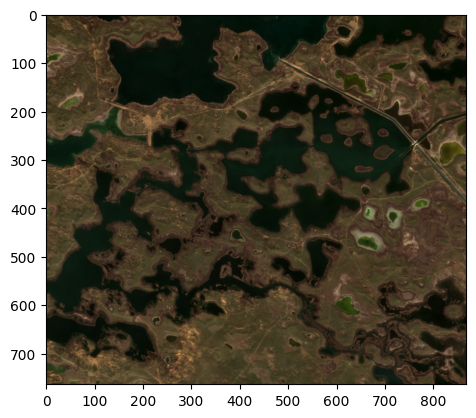

In [214]:
bright = 3.
plt.imshow(bright * arr.transpose((1, 2, 0)) / 10000)

In [215]:
idx = 0

msk = xr.open_rasterio(train_msks[0])
msk

<xarray.DataArray (band: 1, y: 764, x: 868)>
[663152 values with dtype=uint8]
Coordinates:
  * band     (band) int32 1
  * y        (y) float64 4.523e+06 4.523e+06 4.523e+06 ... 4.515e+06 4.515e+06
  * x        (x) float64 3.981e+05 3.982e+05 3.982e+05 ... 4.068e+05 4.068e+05
Attributes:
    transform:      (10.0, 0.0, 398140.0, 0.0, -10.0, 4522700.0)
    crs:            +init=epsg:32642
    res:            (10.0, 10.0)
    is_tiled:       0
    nodatavals:     (0.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area

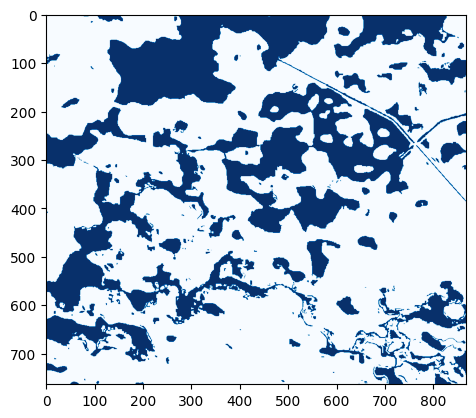

In [216]:
plt.imshow(msk.data.squeeze(), cmap='Blues')

In [217]:
from torchgeo.datasets import RasterDataset

In [218]:
import logging
logger = logging.getLogger("rasterio")
logger.setLevel(logging.ERROR)

In [219]:
root

WindowsPath('../Data/Remote Sensing/WaterDetection/dset-s2')

In [220]:
def scale_image(item: dict):
    item['image'] = item['image'] / 10000
    return item

In [221]:
train_imgs = RasterDataset(root=root/'tra_scene', transforms=scale_image, crs='epsg:3395', res=10)
train_msks = RasterDataset(root=root/'tra_truth', crs='epsg:3395', res=10)

In [222]:
train_msks.is_image = False

In [223]:
len(train_imgs), len(train_msks)

(64, 64)

In [224]:
# type(train_imgs)
type(train_msks)

torchgeo.datasets.geo.RasterDataset

In [225]:
from torchgeo.samplers import RandomGeoSampler, Units

In [292]:
sampler = RandomGeoSampler(train_imgs, size=256, length=150, units=Units.PIXELS)

In [293]:
sample = next(iter(sampler))
sample

BoundingBox(minx=13719832.39879263, maxx=13722392.39879263, miny=9301919.948063724, maxy=9304479.948063724, mint=0.0, maxt=9.223372036854776e+18)

In [294]:
img_sample = train_imgs[sample]
img_sample

{'crs': 'epsg:3395',
 'bbox': BoundingBox(minx=13719832.39879263, maxx=13722392.39879263, miny=9301919.948063724, maxy=9304479.948063724, mint=0.0, maxt=9.223372036854776e+18),
 'image': tensor([[[0.1092, 0.1092, 0.1166,  ..., 0.0725, 0.0739, 0.0739],
          [0.1092, 0.1092, 0.1166,  ..., 0.0725, 0.0739, 0.0739],
          [0.1218, 0.1218, 0.1192,  ..., 0.0733, 0.0741, 0.0741],
          ...,
          [0.1001, 0.1001, 0.1036,  ..., 0.0770, 0.0794, 0.0794],
          [0.0917, 0.0917, 0.0939,  ..., 0.0773, 0.0795, 0.0795],
          [0.0917, 0.0917, 0.0939,  ..., 0.0773, 0.0795, 0.0795]],
 
         [[0.1242, 0.1242, 0.1304,  ..., 0.0687, 0.0686, 0.0686],
          [0.1242, 0.1242, 0.1304,  ..., 0.0687, 0.0686, 0.0686],
          [0.1406, 0.1406, 0.1352,  ..., 0.0691, 0.0668, 0.0668],
          ...,
          [0.0863, 0.0863, 0.0886,  ..., 0.0872, 0.0872, 0.0872],
          [0.0834, 0.0834, 0.0847,  ..., 0.0882, 0.0885, 0.0885],
          [0.0834, 0.0834, 0.0847,  ..., 0.0882, 0.0885

In [295]:
msk_sample = train_msks[sample]
msk_sample

{'crs': 'epsg:3395',
 'bbox': BoundingBox(minx=13719832.39879263, maxx=13722392.39879263, miny=9301919.948063724, maxy=9304479.948063724, mint=0.0, maxt=9.223372036854776e+18),
 'mask': tensor([[[0, 0, 0,  ..., 1, 1, 1],
          [0, 0, 0,  ..., 1, 1, 1],
          [0, 0, 0,  ..., 1, 1, 1],
          ...,
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0]]])}

In [296]:
train_dset = train_imgs & train_msks

In [297]:
train_sample = train_dset[sample]

In [298]:
train_sample.keys()

dict_keys(['crs', 'bbox', 'image', 'mask'])

In [299]:
train_sample['image'].shape, train_sample['mask'].shape

(torch.Size([6, 256, 256]), torch.Size([1, 256, 256]))

In [300]:
from torch.utils.data import DataLoader

In [301]:
from torchgeo.datasets import stack_samples, unbind_samples

In [302]:
dataloader = DataLoader(train_dset, sampler=sampler, batch_size=8, collate_fn=stack_samples)

In [303]:
batch = next(iter(dataloader))

In [304]:
batch.keys()

dict_keys(['crs', 'bbox', 'image', 'mask'])

In [305]:
batch['image'].shape, batch['mask'].shape

(torch.Size([8, 6, 256, 256]), torch.Size([8, 1, 256, 256]))

In [306]:
batch['image'][7].shape

torch.Size([6, 256, 256])

In [307]:
from typing import Iterable, List
import torch

def plot_imgs(images: Iterable, axs: Iterable, chnls: List[int] = [2, 1, 0], bright: float = 3.):
    for img, ax in zip(images, axs):
        arr = torch.clamp(bright * img, min=0, max=1).numpy()
        rgb = arr.transpose(1, 2, 0)[:, :, chnls]
        ax.imshow(rgb)
        ax.axis('off')


def plot_msks(masks: Iterable, axs: Iterable):
    for mask, ax in zip(masks, axs):
        ax.imshow(mask.squeeze().numpy(), cmap='Blues')
        ax.axis('off')


def plot_batch(batch: dict, bright: float = 3., cols: int = 4, width: int = 5, chnls: List[int] = [2, 1, 0]):

    # Get the samples and the number of items in the batch
    samples = unbind_samples(batch.copy())
    
    # if batch contains images and masks, the number of images will be doubled
    n = 2 * len(samples) if ('image' in batch) and ('mask' in batch) else len(samples)

    # calculate the number of rows in the grid
    rows = n//cols + (1 if n%cols != 0 else 0)

    # create a grid
    _, axs = plt.subplots(rows, cols, figsize=(cols*width, rows*width))  

    if ('image' in batch) and ('mask' in batch):
        # plot the images on the even axis
        plot_imgs(images=map(lambda x: x['image'], samples), axs=axs.reshape(-1)[::2], chnls=chnls, bright=bright) #type: ignore

        # plot the masks on the odd axis
        plot_msks(masks=map(lambda x: x['mask'], samples), axs=axs.reshape(-1)[1::2]) #type: ignore

    else:

        if 'image' in batch:
            plot_imgs(images=map(lambda x: x['image'], samples), axs=axs.reshape(-1), chnls=chnls, bright=bright) #type: ignore
    
        elif 'mask' in batch:
            plot_msks(masks=map(lambda x: x['mask'], samples), axs=axs.reshape(-1)) #type: ignore

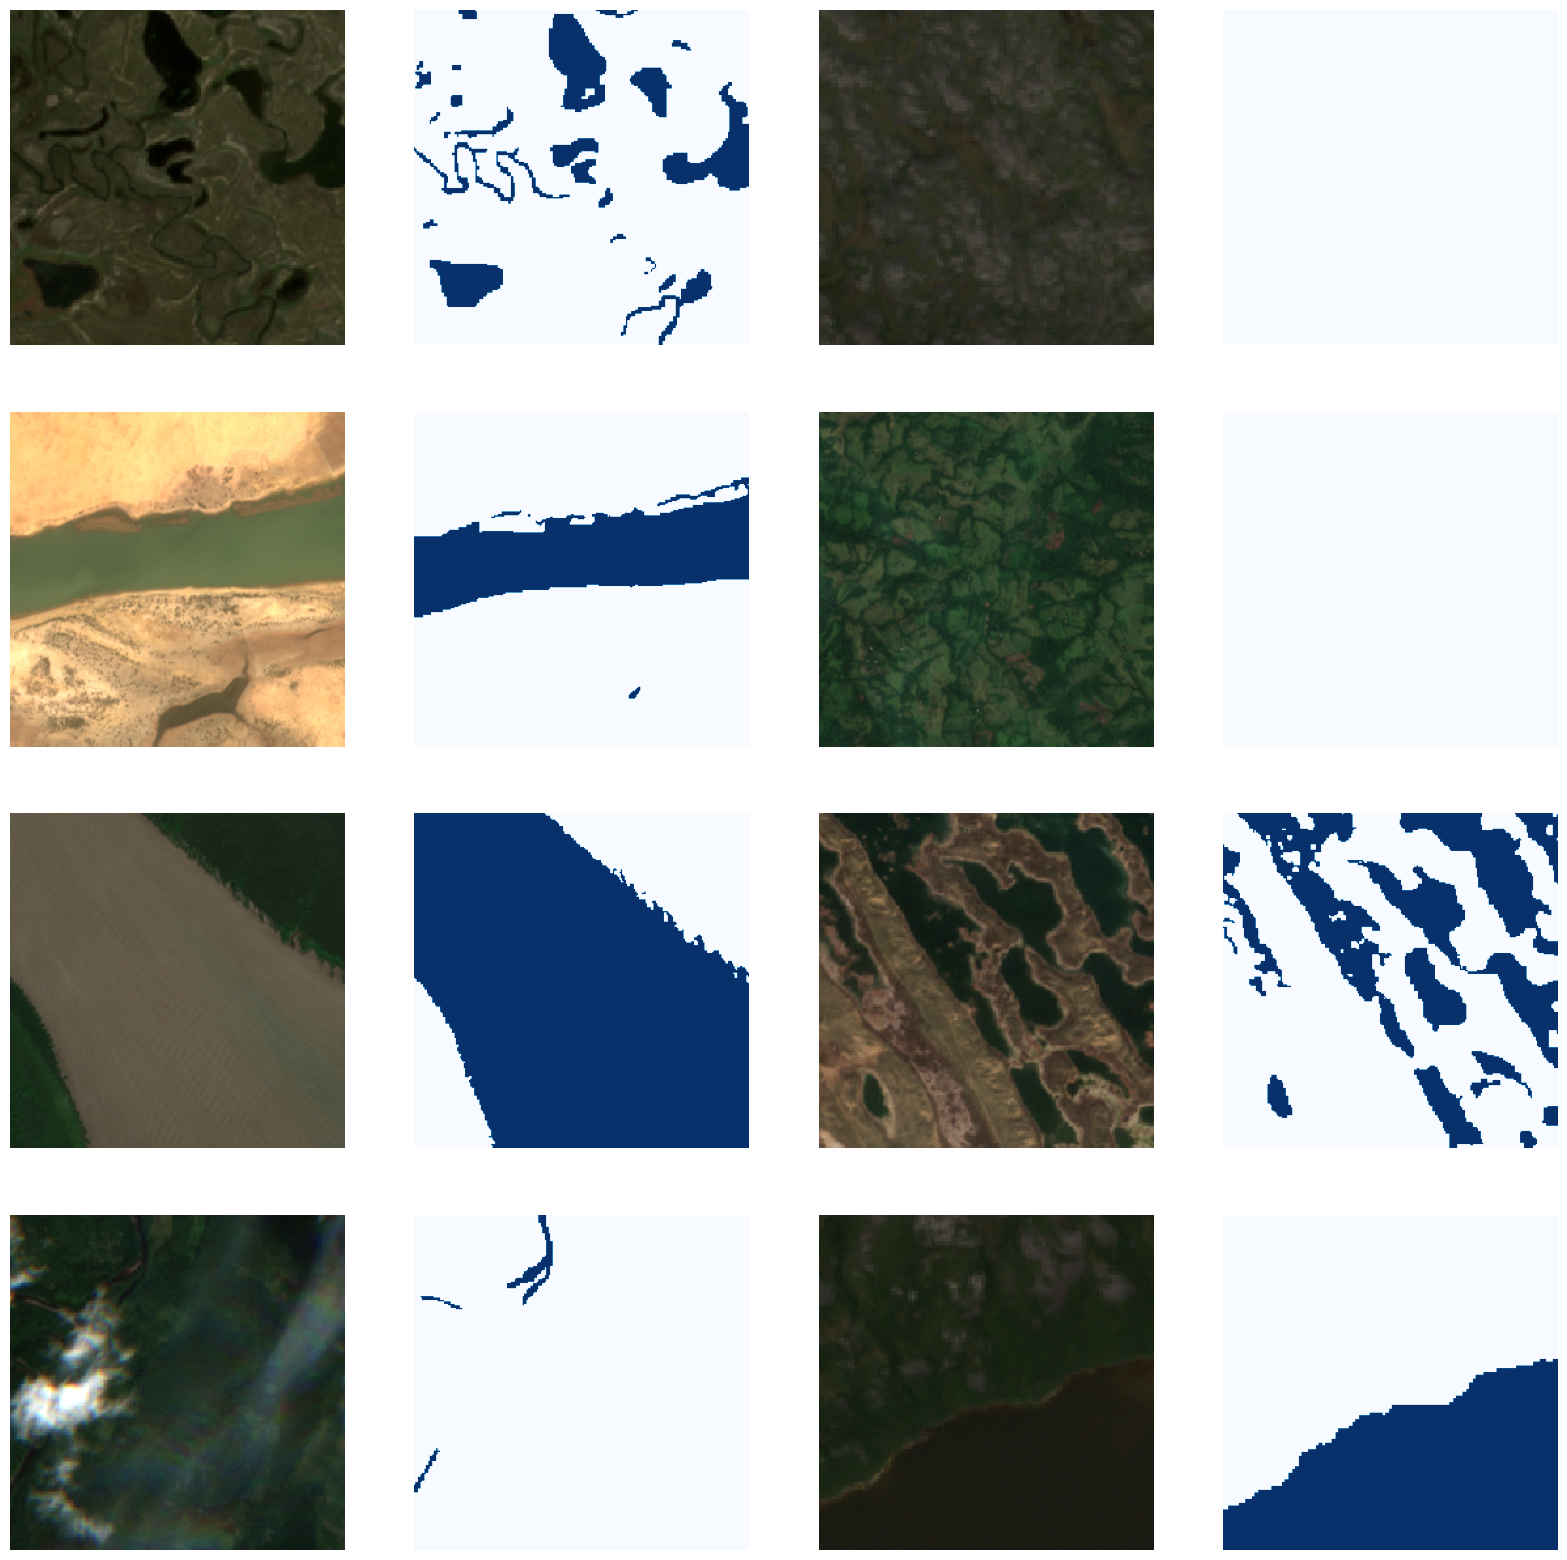

In [308]:
plot_batch(batch)

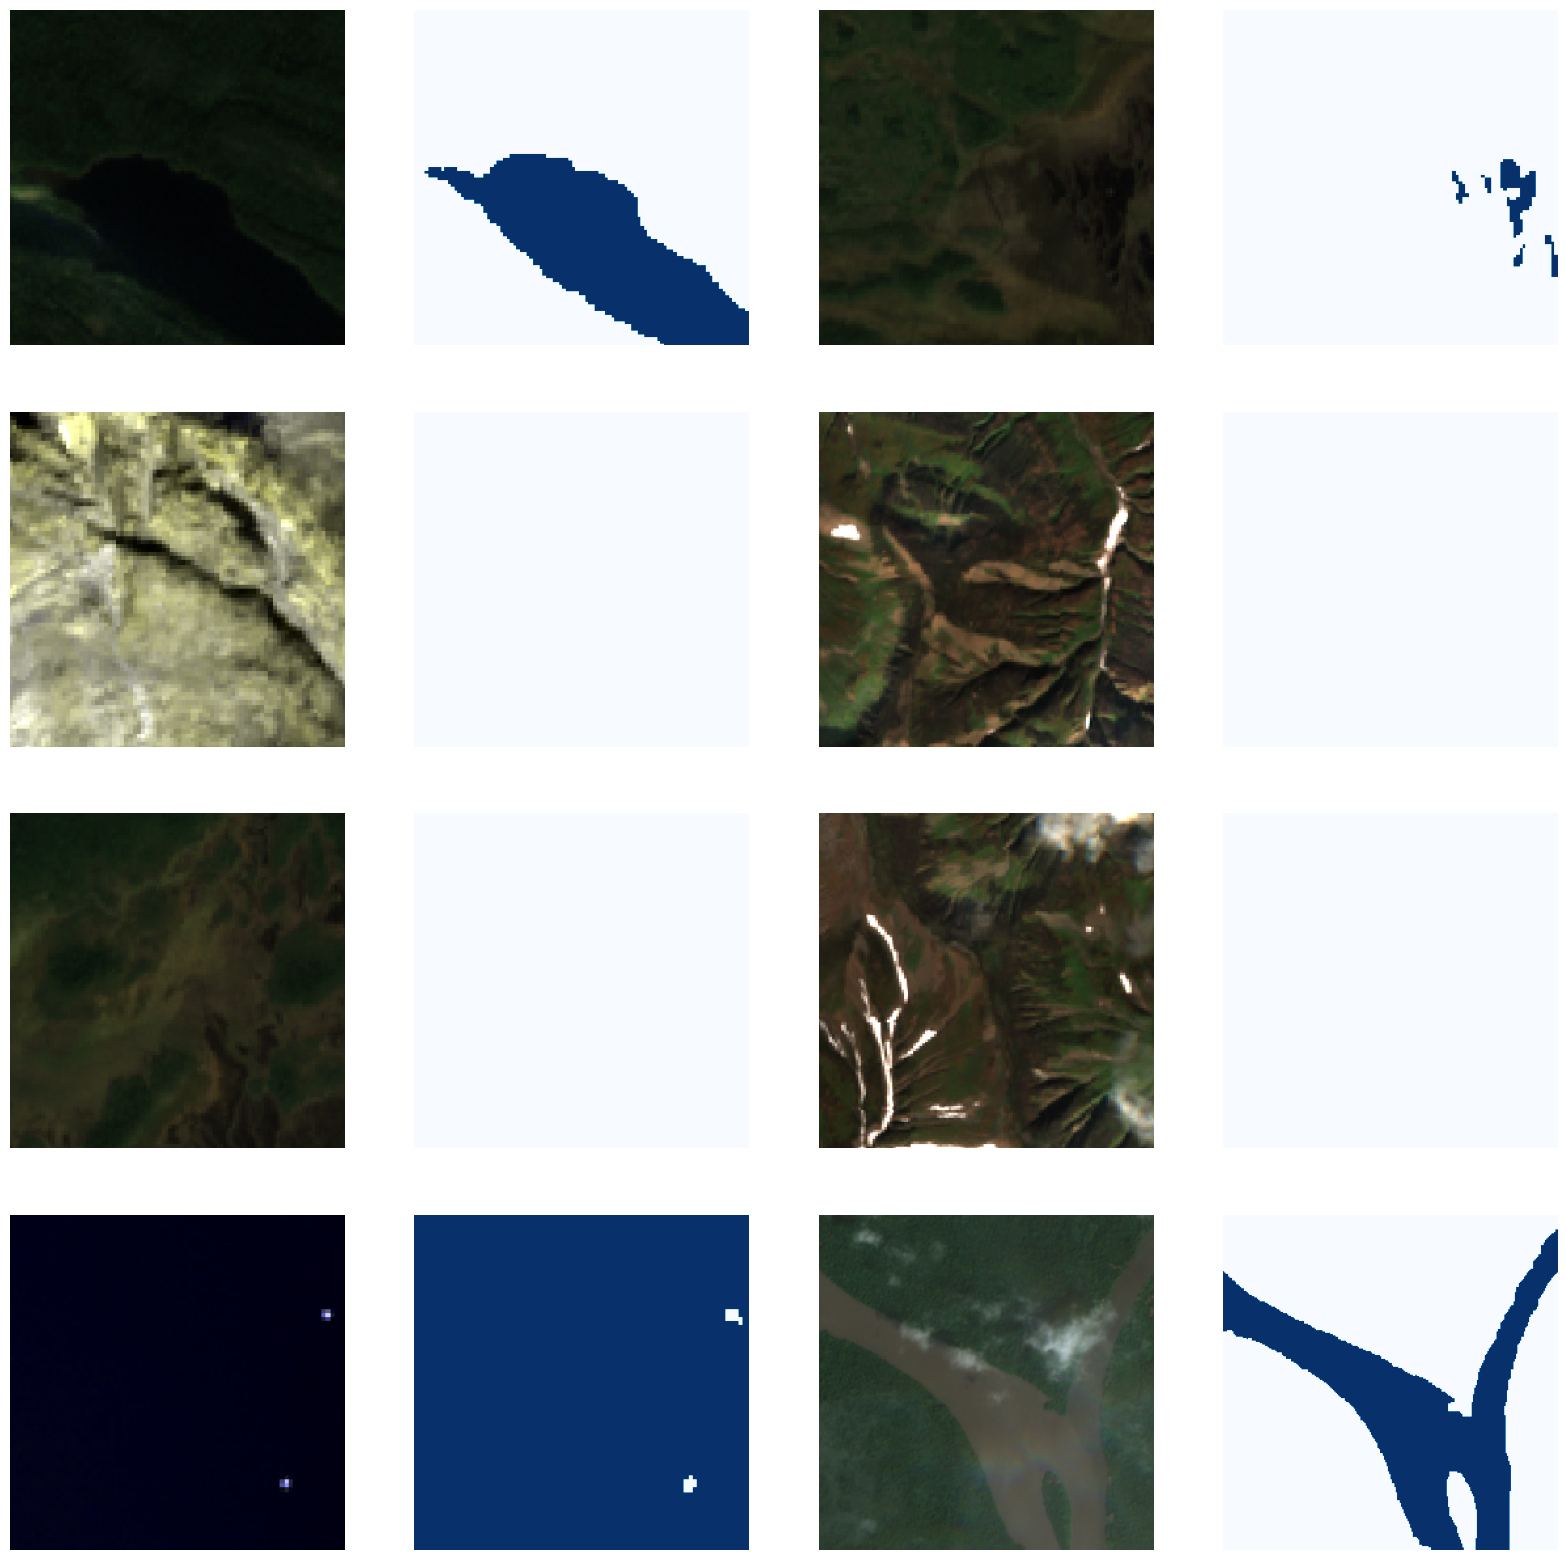

In [309]:
batch = next(iter(dataloader))
plot_batch(batch)

In [310]:
# MNDWI (Modified Normalized Water Index)
# (Green - SWIR) / (Green + SWIR)
# NDWI -> MNDWI

from torchgeo.transforms import indices

In [311]:
from torchgeo.transforms import indices

mndwi_transform = indices.AppendNDWI(index_green=1, index_nir=4)
ndwi_transform = indices.AppendNDWI(index_green=1, index_nir=3)
ndvi_transform = indices.AppendNDVI(index_nir=3, index_red=2)
tfms = torch.nn.Sequential(ndwi_transform, ndwi_transform, ndvi_transform)

transformed_batches = []
for batch in dataloader:
    transformed_images = tfms(batch['image'])
    transformed_batch = {**batch, 'image': transformed_images}
    transformed_batches.append(transformed_batch)


In [312]:
print(transformed_batches[0]['image'].shape)
print(transformed_batches[3]['mask'].shape)

torch.Size([8, 9, 256, 256])
torch.Size([8, 1, 256, 256])


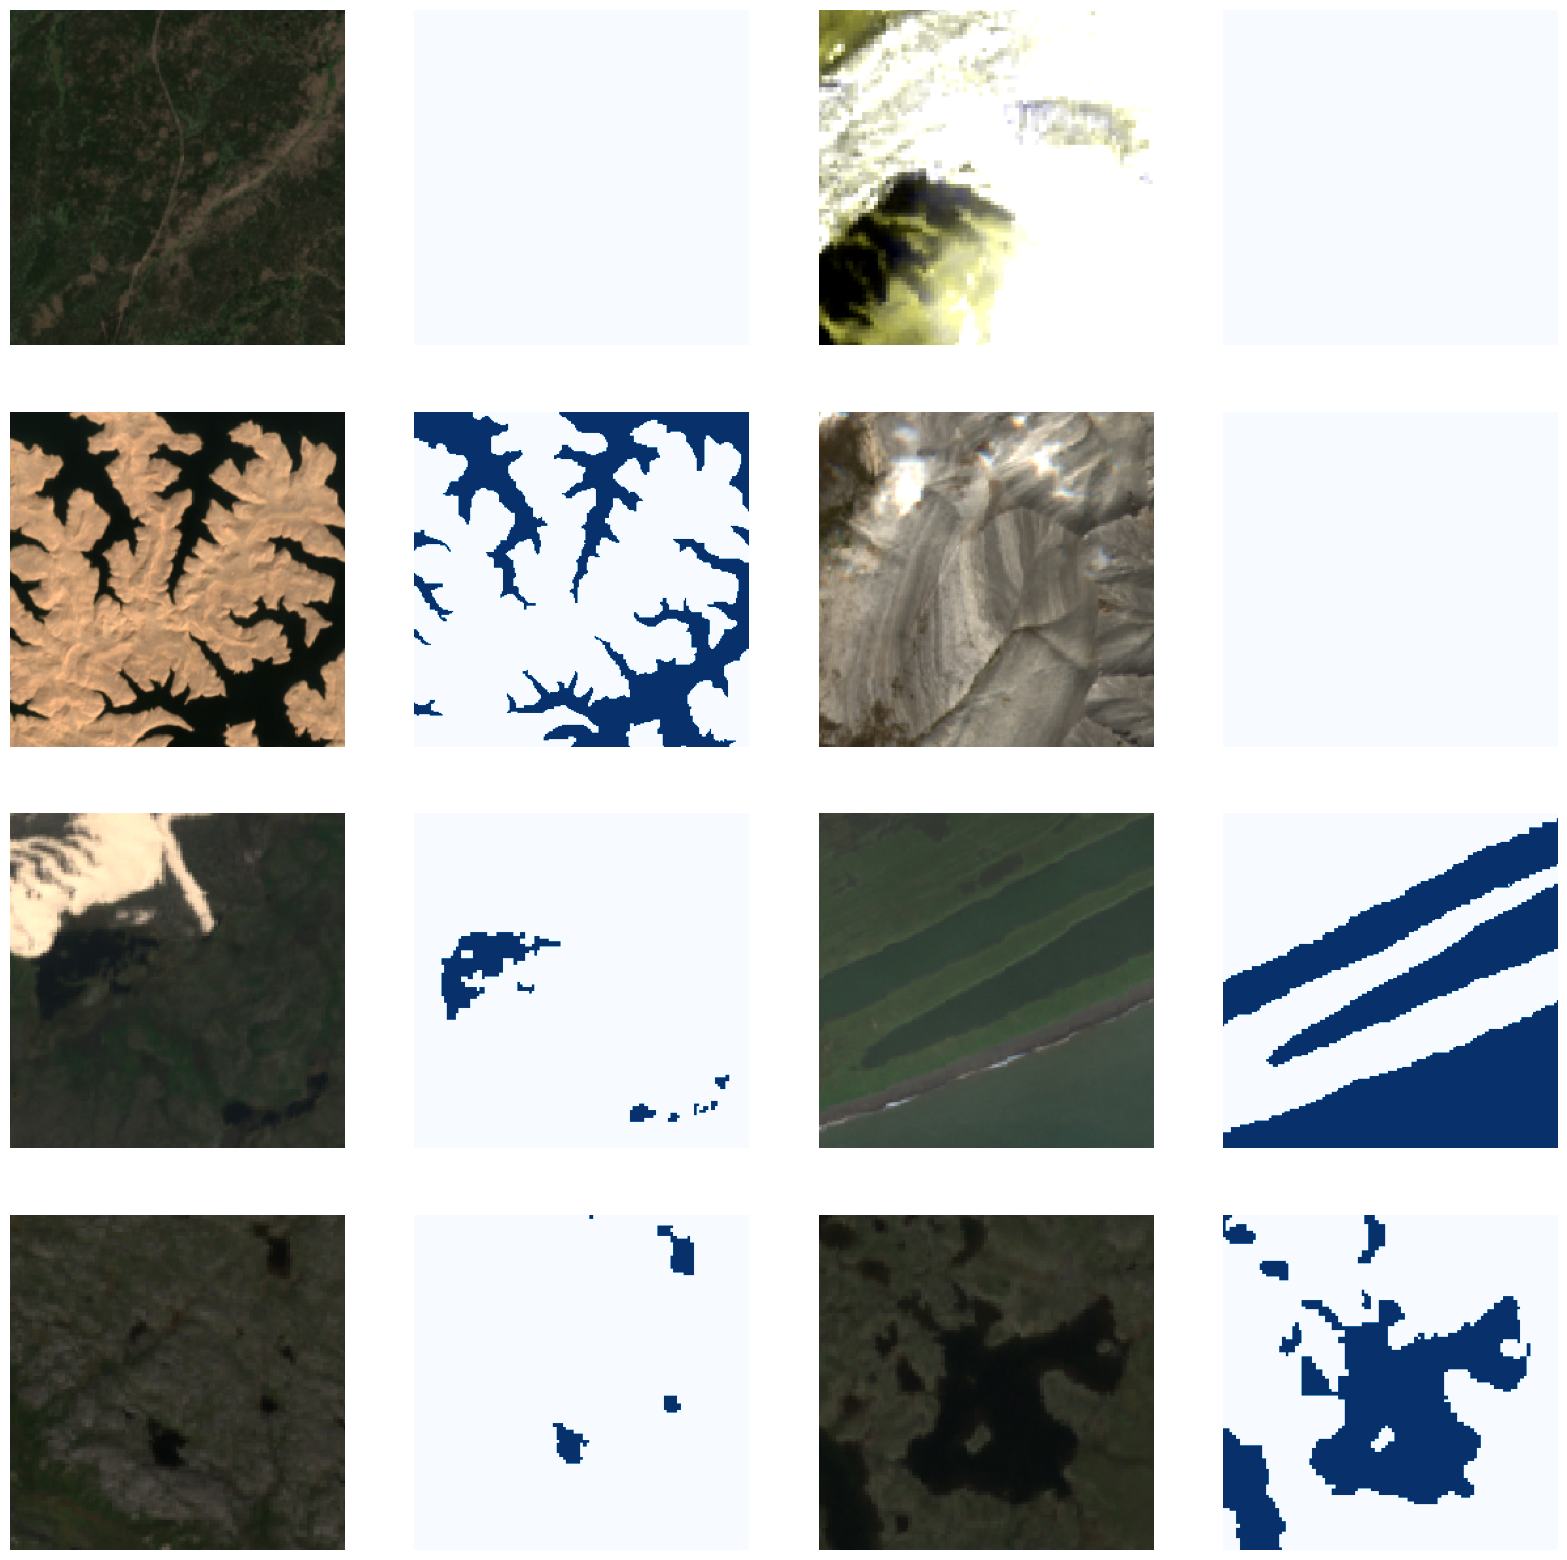

In [313]:
plot_batch(transformed_batches[0])

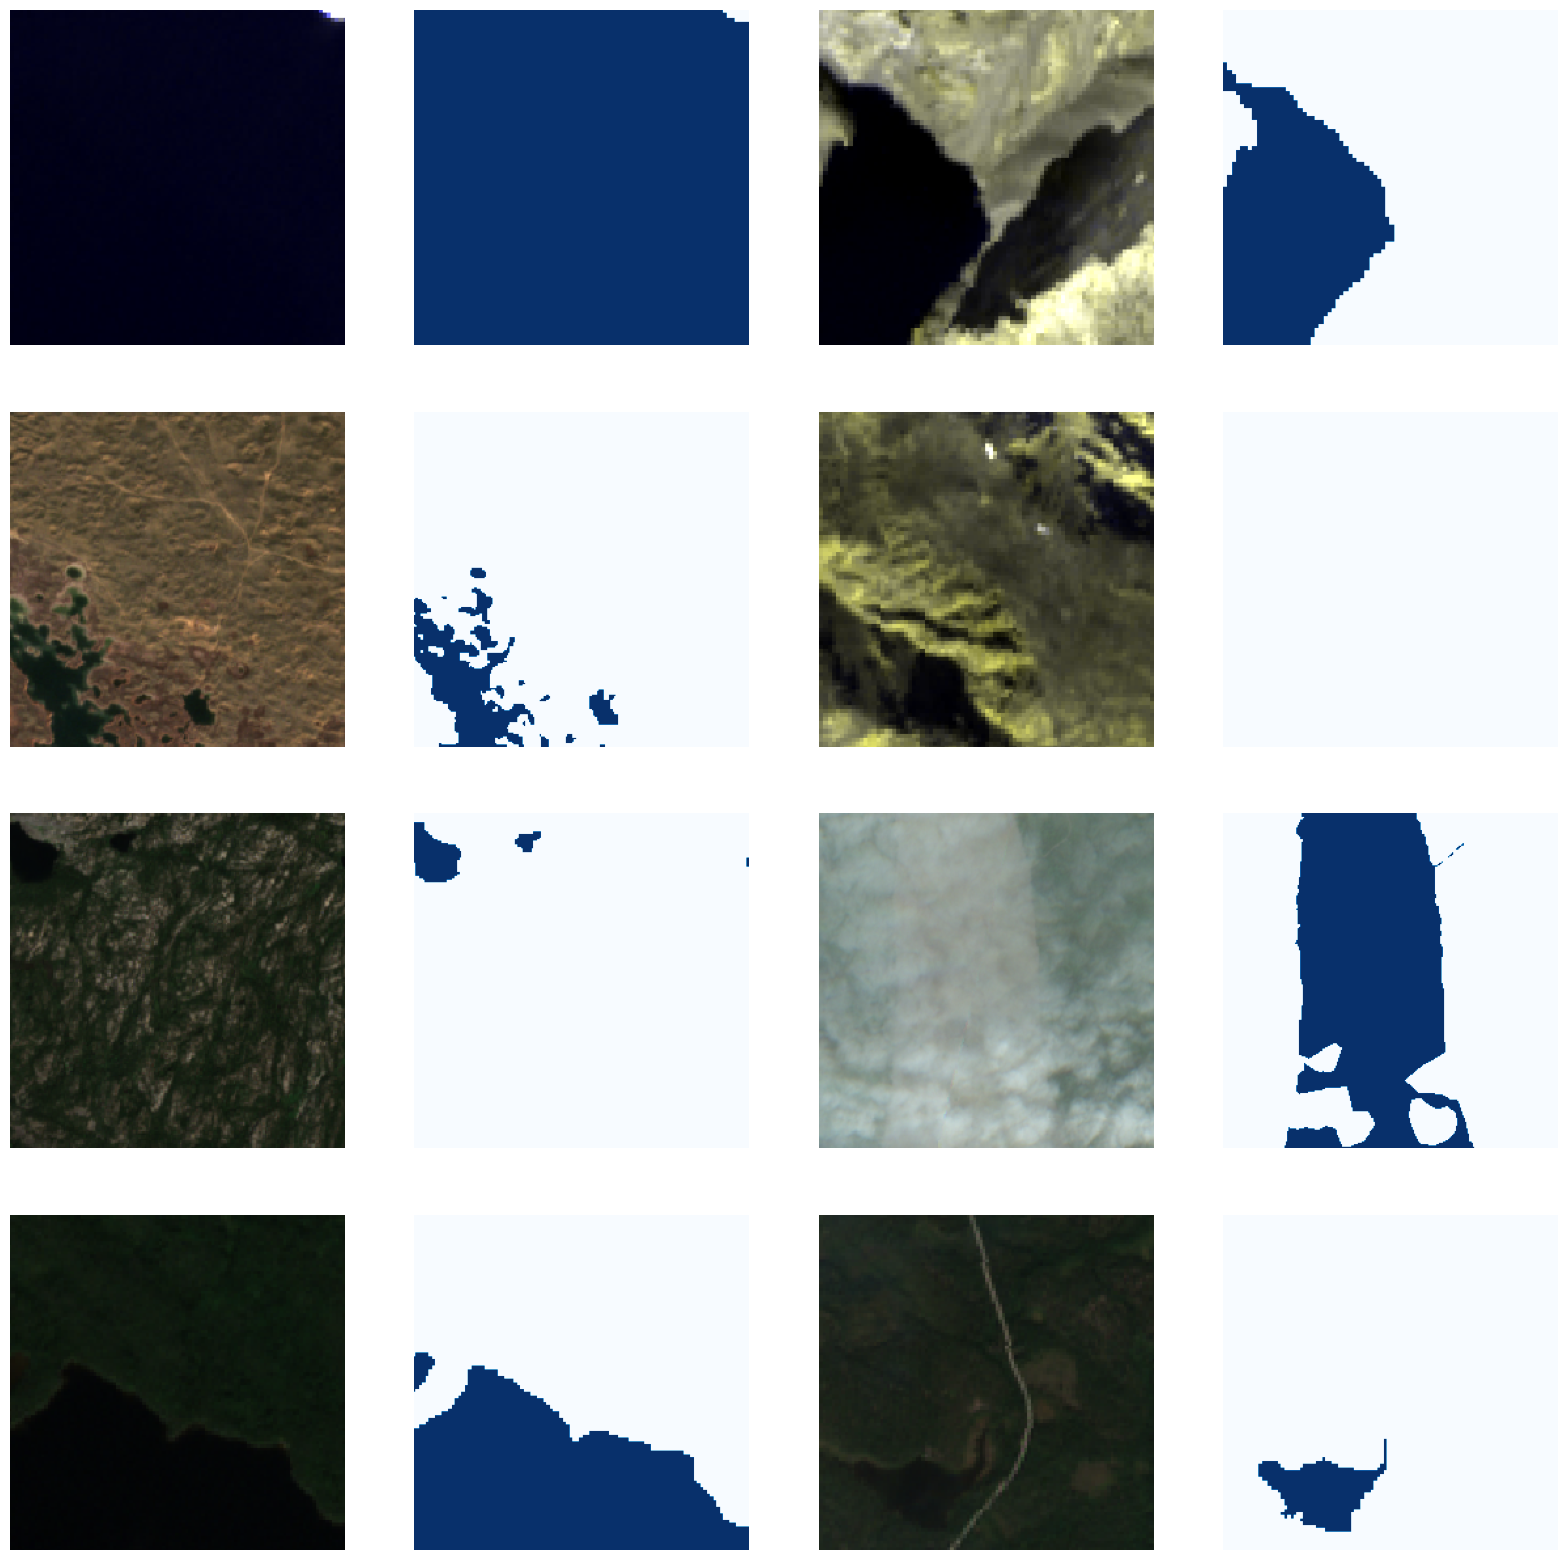

In [314]:
plot_batch(transformed_batches[3])

In [315]:
len(transformed_batches)

19

In [317]:
import numpy as np

In [318]:
images = []
masks = []

# Iterate over each batch
for batch in transformed_batches:
    batch_images = np.array(batch['image'])
    batch_masks = np.squeeze(np.array(batch['mask']), axis=1)

    # Reshape the arrays
    batch_images = np.reshape(batch_images, (batch_images.shape[0], batch_images.shape[1], batch_images.shape[2], batch_images.shape[3]))
    batch_masks = np.reshape(batch_masks, (batch_masks.shape[0], batch_masks.shape[1], batch_masks.shape[2]))

    images.append(batch_images)
    masks.append(batch_masks)

# Concatenate all batches
images = np.concatenate(images)
masks = np.concatenate(masks)

In [323]:
images.shape
masks.shape

(150, 256, 256)